# 사례 연구 1: 출현-전용 데이터를 이용한 팔색조(Pitta nympha) 서식지 적합성 및 예측 분포 모델링

In [1]:
import ee
import geemap

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Earth Engine 인증
# ee.Authenticate()

# Earth Engine 초기화
ee.Initialize()

In [3]:
# geemap 빈 지도 객체 생성
Map = geemap.Map()

In [4]:
# 입력 파일 경로
input_gpkg_file = 'pitta_nympha_data.gpkg'

# GeoPackage 파일 로드
gdf = gpd.read_file(input_gpkg_file)[["species", "year", "month", "geometry"]]

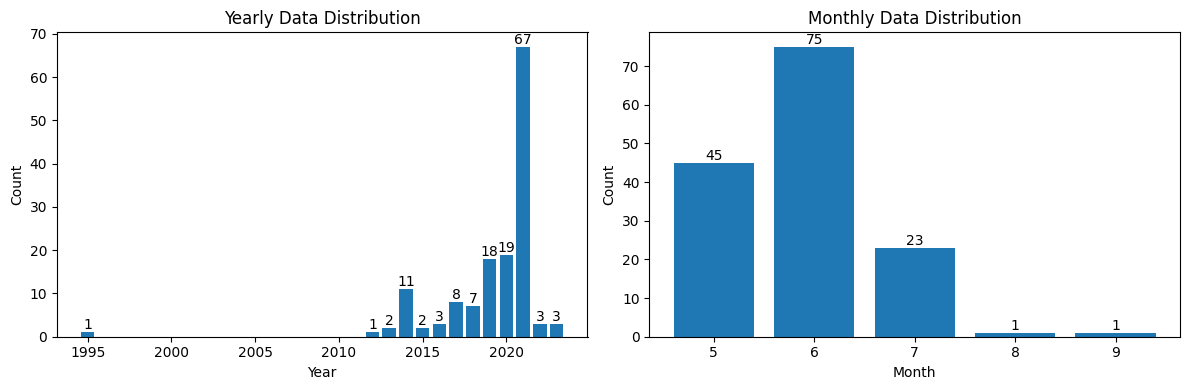

In [5]:
def plot_data_distribution(gdf):
    
    # 연도별 데이터 분포 그래프 (왼쪽)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')
    
    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')
    
    # 월별 데이터 분포 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')
    
    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # x 축의 눈금을 정수 형식으로 설정
    plt.xticks(month_counts.index, map(int, month_counts.index))
    
    # 그래프 출력
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

plot_data_distribution(gdf)

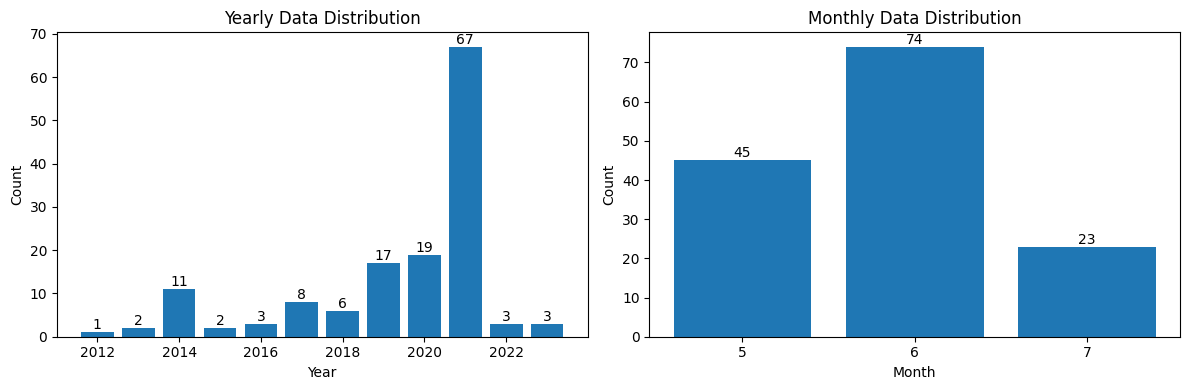

In [6]:
# 연도와 월 기반으로 필터링
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

plot_data_distribution(filtered_gdf)

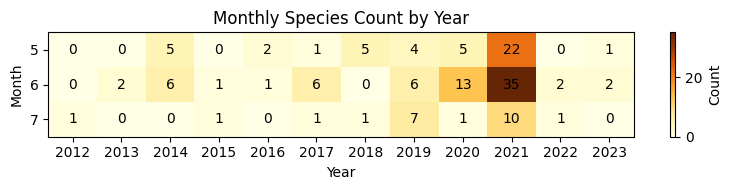

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     0     1
6         0     2     6     1     1     6     0     6    13    35     2     2
7         1     0     0     1     0     1     1     7     1    10     1     0


In [7]:
def plot_heatmap_from_gdf(gdf):
    # 필요한 통계 계산
    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)
    
    # 히트맵으로 통계 시각화
    plt.figure(figsize=(8, 2))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # 각 픽셀 위에 수치 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()

# 히트맵 그래프 출력 함수 호출
plot_heatmap_from_gdf(filtered_gdf)

# 통계 테이블 출력
print(filtered_gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

In [8]:
# 출력 파일 경로
output_shapefile = 'pitta_nympha_data.shp'

# shapefile로 저장
filtered_gdf.to_file(output_shapefile)

# 출현(presence) 원시 데이터 추가
data_raw = geemap.shp_to_ee(output_shapefile)

In [9]:
# 작업할 공간 해상도 설정(m)
GrainSize = 1000

def remove_duplicates(data, GrainSize):
    # 선택한 공간 해상도(1km)에서 픽셀 당 출현 기록 하나만 무작위 선택
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

Data = remove_duplicates(data_raw, GrainSize)

In [10]:
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 142
Final data size: 95


In [11]:
vis_params = {'color': 'blue'}
Map.addLayer(data_raw, vis_params, 'Original data')
Map.centerObject(data_raw.geometry(), 7)

vis_params = {'color': 'red'}
Map.addLayer(Data, vis_params, 'Final data')
Map.centerObject(Data.geometry(), 7)

Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…